In [1]:
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

import cityImage as ci

In [13]:
# initialise path, names, etc.
city_name = 'Paris'
epsg = 27571
crs = 'EPSG:'+str(epsg)

### Download the street network

Choose between the following methods:
* `OSMplace`, providing an OSM place name (e.g. City).
* `OSMpolygon`, provide a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter (which is otherwise not necessary)

Downloading the graph and cleaning it (see the notebook *01-Nodes_Paths_fromOSM* for details on the cleaning process)

In [4]:
place = 'Paris, Ile-de-France'
download_method = 'OSMpolygon'
distance = None
nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'walk', epsg, distance = distance)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            self_loops = True, same_vertexes_edges = True)

### Loading from local path

In [3]:
loading_path = 'Outputs/'+city_name+'/largeNetwork/'
nodes_graph = gpd.read_file(loading_path+city_name+'_nodes.shp')
edges_graph = gpd.read_file(loading_path+city_name+'_edges.shp')

nodes_graph.index, edges_graph.index  = nodes_graph.nodeID, edges_graph.edgeID
nodes_graph.index.name, edges_graph.index.name  = None, None

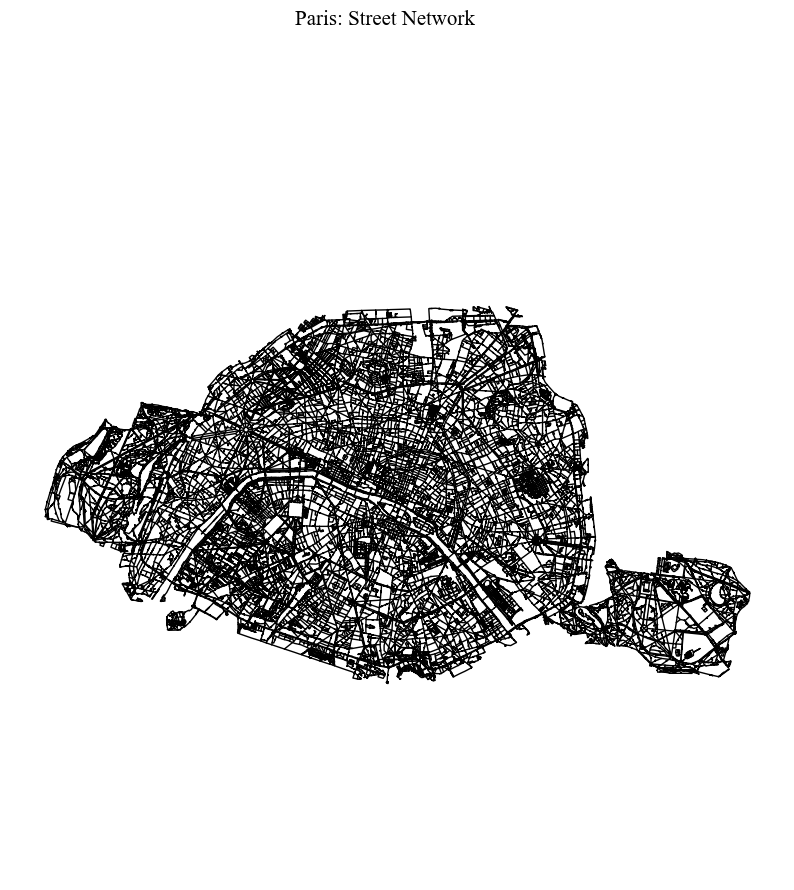

In [11]:
fig = ci.plot_gdf(edges_graph, scheme = None, black_background = False, geometry_size = 1.0, alpha = 1.0, 
            color = 'black', title = city_name+': Street Network', figsize = (10,10))

## Barriers identification

Choose between the following methods:
* `OSMplace`, providing an OSM place name (e.g. City).
* `OSMpolygon`, provide a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter (which is otherwise not necessary)

In [6]:
# defining the method and creating the envelope with wgs coordinate system
download_method = 'polygon'
place = ci.envelope_wgs(edges_graph)
distance = None

In [25]:
road_barriers = ci.road_barriers(place, download_method, distance, epsg, include_primary = True)

In [21]:
# road_barriers = ci.road_barriers(place, download_method, distance, epsg, include_primary = True, include_secondary = False)
water_barriers = ci.water_barriers(place, download_method, distance, epsg)
railway_barriers = ci.railway_barriers(place, download_method, distance, epsg)
park_barriers = ci.park_barriers(place, download_method, distance, epsg, min_area = 100000)

CRSError: Invalid projection: EPSG:None: (Internal Proj Error: proj_create: crs not found)

In [ ]:
barriers = road_barriers.append(water_barriers)
barriers = railway_barriers.append(barriers)
barriers = park_barriers.append(barriers)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

envelope = edges_graph.unary_union.envelope
barriers_within = barriers[barriers.intersects(edges_graph.unary_union.envelope)]

### Visualisation

In [ ]:
barriers_within.sort_values(by = 'barrier_type', ascending = False, inplace = True)  
colors = ['green', 'red', 'gray', 'blue']
ci.plot_barriers(barriers_within, black_background = False, title = city_name+': Barriers', legend = True)

In [11]:
# saving barriers_gdf
saving_path = 'Outputs/'+city_name+'/'
barriers.to_file(saving_path+city_name+"_barriers.shp", driver='ESRI Shapefile')

### Assigning barriers to street segments

### Type of barriers

* *Positive barriers*, from a pedestrian perspective: Waterbodies, Parks.
* *Negative barriers*, from a pedestrian perspective: Major Roads, Railway Structures.
* *Structuring barriers* - Barriers which structure and shape the image of the city: Waterbodies, Major roads, Railways.

In [12]:
sindex = edges_graph.sindex

# along and within POSITIVE BARRIERS
# rivers
edges_graph = ci.along_water(edges_graph, barriers_within)
# parks
edges_graph = ci.along_within_parks(edges_graph, barriers_within)
# altogheter
edges_graph['p_barr'] = edges_graph['a_rivers']+edges_graph['aw_parks']
edges_graph['p_barr'] = edges_graph.apply(lambda row: list(set(row['p_barr'])), axis = 1)

# along NEGATIVE BARRIERS                                    
tmp = barriers_within[barriers_within['type'].isin(['railway', 'road'])]
edges_graph['n_barr'] = edges_graph.apply(lambda row: ci.barriers_along(row['edgeID'], edges_graph, tmp, sindex,
                                            offset = 25), axis = 1)

# crossing any kind of barrier but parks - STRUCTURING BARRIERS
edges_graph = ci.assign_structuring_barriers(edges_graph, barriers_within)

## Visualisation

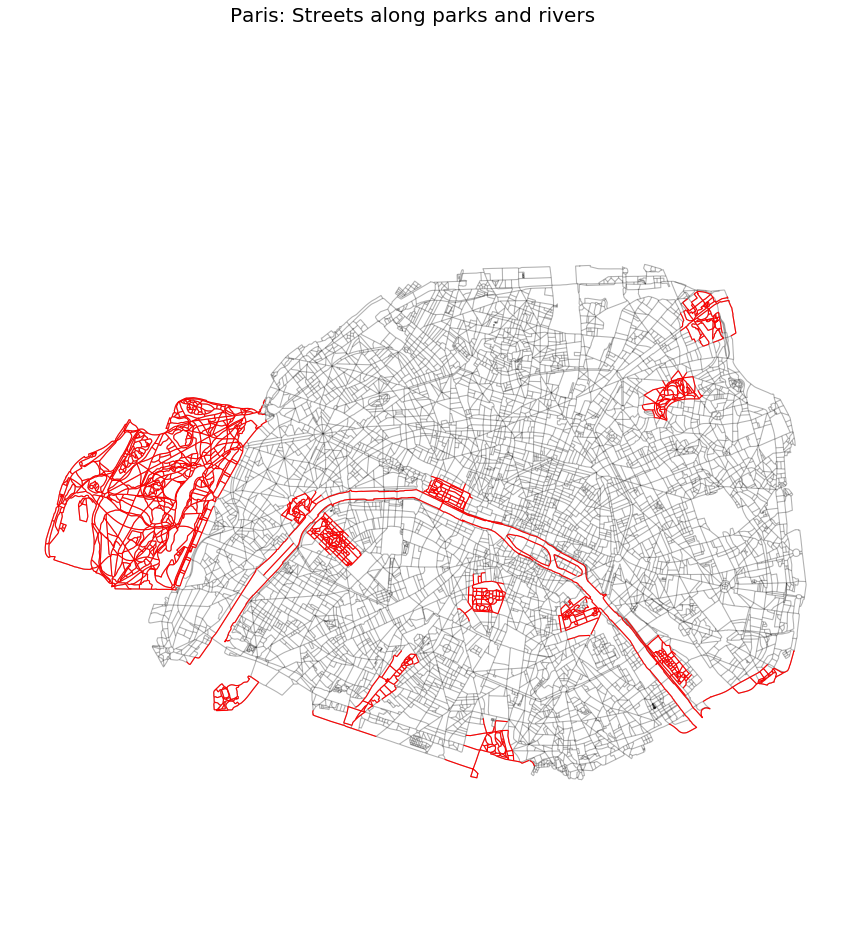

In [13]:
# positive barriers
edges_graph['p_bool'] = edges_graph.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.p_bool == True].copy()
ci.plot_gdf(tmp, black_background = False, fig_size = 15, color = 'red', title = city_name+': Streets along parks and rivers', 
              legend = False, gdf_base_map = edges_graph, base_map_alpha = 0.3, base_map_color = 'black')

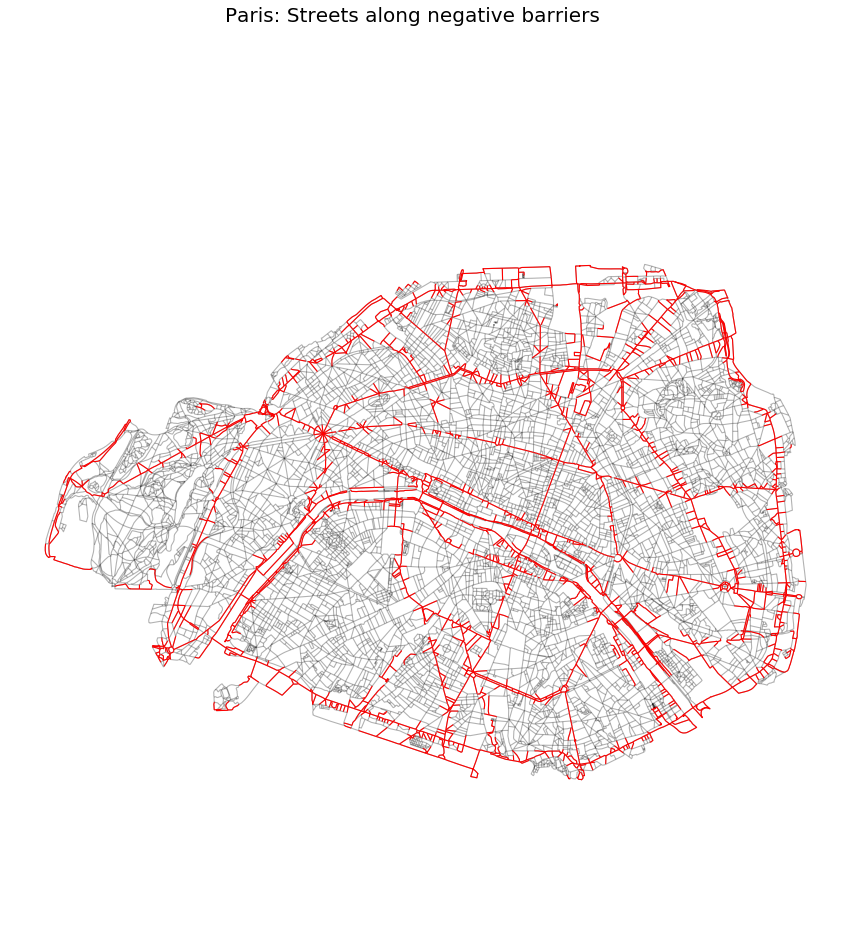

In [15]:
# negative barriers
edges_graph['n_bool'] = edges_graph.apply(lambda row: True if len(row['n_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.n_bool == True].copy()
ci.plot_gdf(tmp, black_background = False, fig_size = 15, color = 'red', title = city_name+': Streets along negative barriers',
              legend = False, gdf_base_map = edges_graph, base_map_alpha = 0.3, base_map_color = 'black')

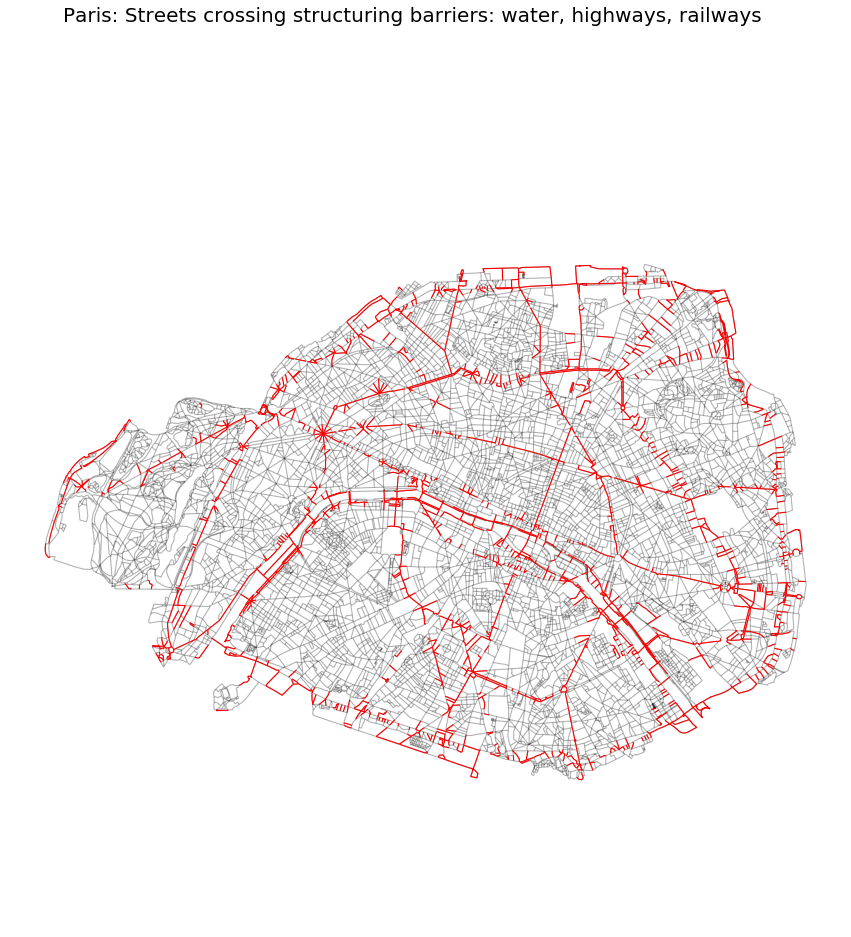

In [14]:
# separating barriers
tmp = edges_graph[edges_graph.sep_barr == True].copy()
ci.plot_gdf(tmp, black_background = False, fig_size = 15,  color = 'red', 
              title = city_name+': Streets crossing structuring barriers: water, highways, railways',
              gdf_base_map = edges_graph, base_map_alpha = 0.3, base_map_color = 'black', legend = False)

### Save 

In [6]:
# convertin list fields to string
to_convert = ['a_rivers', 'aw_parks','n_barr', 'p_barr']
edges_graph_string = edges_graph.copy()
for column in to_convert: edges_graph_string[column] = edges_graph_string[column].astype(str)

saving_path = 'Outputs/'+city_name+'/'
edges_graph_string.to_file(saving_path+city_name+"_edges_simplified.shp", driver='ESRI Shapefile')
nodes_graph.to_file(saving_path+city_name+'_nodes_simplified.shp', driver='ESRI Shapefile')